In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import torch

from utils.visualization import display_image_pair
from utils.dataset import read_config, load_dataset
from utils.correspondence import preprocess_image, preprocess_points, preprocess_bbox, compute_pck_img, compute_pck_bbox, postprocess_points

from models.luo import LuoModel
from models.hedlin import HedlinModel
from models.tang import TangModel
from models.zhang import ZhangModel

/export/home/ra63des/miniconda3/envs/distilldift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_type = 'hedlin'
dataset_config = 'dataset_config.json'
device_type = 'cuda'
pck_threshold = 0.1

In [4]:
# Load model
if model_type == 'luo':
    image_size = (224, 224)
    model = LuoModel(1, image_size, device_type)
elif model_type == 'hedlin':
    image_size = (512, 512)
    model = HedlinModel(image_size, device_type, float16=False)
elif model_type == 'tang':
    image_size = (768, 768)
    model = TangModel(image_size, device_type)
elif model_type == 'zhang':
    image_size = (960, 960)
    batch_size = 1
    model = ZhangModel(1, image_size, device_type)

device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_config(dataset_config)

# Define preprocessor
def preprocess(sample):
    source_size = sample['source_image'].size
    target_size = sample['target_image'].size
    sample['source_image'] = preprocess_image(sample['source_image'], image_size)
    sample['target_image'] = preprocess_image(sample['target_image'], image_size)
    sample['source_points'] = preprocess_points(sample['source_points'], source_size, image_size)
    sample['target_points'] = preprocess_points(sample['target_points'], target_size, image_size)
    sample['source_bbox'] = preprocess_bbox(sample['source_bbox'], source_size, image_size)
    sample['target_bbox'] = preprocess_bbox(sample['target_bbox'], target_size, image_size)
    return sample

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 27094.99it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Evaluating dataset: SPair-71k


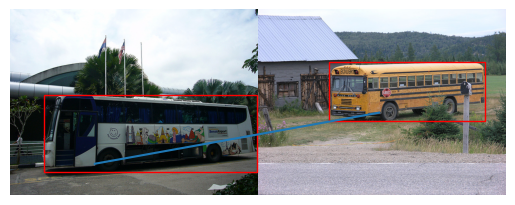

In [5]:
# Evaluate
config = dataset_config[0]
print(f"Evaluating dataset: {config['name']}")
dataset = load_dataset(config)

# Take first sample
unprocessed_sample = dataset[0]

# Use only 1 keypoint for Hedlin et al. because of time constraints
if model_type == 'hedlin':
    rand_i = torch.randint(0, unprocessed_sample['source_points'].shape[0], (1,)).item()
    unprocessed_sample['source_points'] = unprocessed_sample['source_points'][rand_i, :].unsqueeze(0)
    unprocessed_sample['target_points'] = unprocessed_sample['target_points'][rand_i, :].unsqueeze(0)

# Visualize sample
display_image_pair(unprocessed_sample, show_bbox=True)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))
sample['source_image'] = sample['source_image'].unsqueeze(0)
sample['target_image'] = sample['target_image'].unsqueeze(0)
sample['source_points'] = sample['source_points'].unsqueeze(0)
sample['target_points'] = sample['target_points'].unsqueeze(0)
sample['source_bbox'] = sample['source_bbox'].unsqueeze(0)
sample['target_bbox'] = sample['target_bbox'].unsqueeze(0)
sample['category'] = [sample['category']]

# load images on device
sample['source_image'] = sample['source_image'].to(device)
sample['target_image'] = sample['target_image'].to(device)

In [6]:
# run through model
with torch.set_grad_enabled(model_type == 'hedlin'):
    predicted_points = model(sample)

/export/home/ra63des/miniconda3/envs/distilldift/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


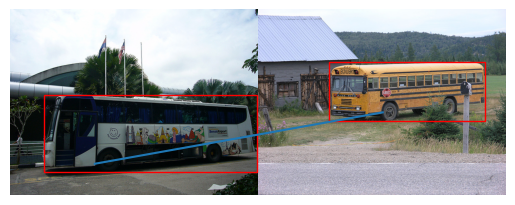

In [7]:
predicted_sample = copy.deepcopy(unprocessed_sample)
predicted_sample['target_points'] = postprocess_points(predicted_points[0], image_size, unprocessed_sample['target_image'].size)

display_image_pair(predicted_sample, show_bbox=True)

In [8]:
# calculate PCK values
target_points = sample['target_points']
source_points = sample['source_points']
target_bbox = sample['target_bbox']
pck_img = compute_pck_img(predicted_points[0], target_points[0], image_size, pck_threshold)
pck_bbox = compute_pck_bbox(predicted_points[0], target_points[0], target_bbox[0], pck_threshold)
keypoints = len(source_points[0])

print(f"pck_img: {pck_img / keypoints}, pck_bbox: {pck_bbox / keypoints}")

pck_img: 1.0, pck_bbox: 1.0
